In [2]:
import numpy as np
import pandas as pd

In [3]:
import os 
import sys
sys.path.append(os.path.abspath('../common')) # add path to common functions

In [15]:
from preprocess import getdfs

train_df, valid_df = getdfs(data = 'text_seq')

In [16]:
train_df.head()

,input_str,label
0,0000154364642718159661428002624223132284159626...,0
1,0004641596369515436422262614110471596262476161...,0
2,0001543626215965999614422464135806142624051159...,0
3,0000154364224641238614262159689561596284351061...,1
4,0004641899422154362069015966142624761262159661...,1


In [17]:
from preprocess import process_strings

train_df['input_str'] = process_strings(train_df['input_str'])
valid_df['input_str'] = process_strings(valid_df['input_str'])


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(analyzer='char')

# Fit and transform the data
x_train = vectorizer.fit_transform(train_df["input_str"])
x_valid = vectorizer.transform(valid_df["input_str"])
y_train = train_df["label"]
y_valid = valid_df["label"]

In [19]:
x_train = x_train.toarray()
x_valid = x_valid.toarray()

In [29]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

# Define the DNN model
def create_model(lr=0.001):
    model = models.Sequential()
    
    # Input layer (10 input features)
    model.add(layers.InputLayer(shape=(10,)))
    
    # Hidden layers
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal'))  # First hidden layer
    model.add(layers.Dropout(0.3))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal'))  # Second hidden layer
    model.add(layers.Dropout(0.3))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal'))  # Second hidden layer
    model.add(layers.Dropout(0.3))
    model.add(layers.BatchNormalization())
    
    # Output layer
    # Assuming binary classification; adjust output neurons and activation for multi-class or regression
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class, 'mse' for regression
                  metrics=['accuracy'])
    
    return model

In [30]:
model = create_model(lr = 0.001)

In [32]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,473 (37.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)

In [34]:
# Train the model
history = model.fit(x_train, y_train, 
                    validation_data=(x_valid, y_valid), 
                    epochs=30,  # Set your number of epochs
                    batch_size=16)  # Set an appropriate batch size

Epoch 1/30


443/443 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5040 - loss: 1.1976 - val_accuracy: 0.5133 - val_loss: 1.0538
Epoch 2/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5059 - loss: 1.0737 - val_accuracy: 0.5153 - val_loss: 1.0059
Epoch 3/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5008 - loss: 1.0122 - val_accuracy: 0.5051 - val_loss: 0.9650
Epoch 4/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4973 - loss: 0.9601 - val_accuracy: 0.4826 - val_loss: 0.9255
Epoch 5/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5001 - loss: 0.9156 - val_accuracy: 0.4847 - val_loss: 0.8816
Epoch 6/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5013 - loss: 0.8739 - val_accuracy: 0.4928 - val_loss: 0.8457
Epoch 7/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5164 - loss: 0.8341 - val_accuracy: 0.4806 - val_loss: 0.8152
Epoch 8/30
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5197 - loss: 0.8012 - val_accuracy: 0.4888 - val_

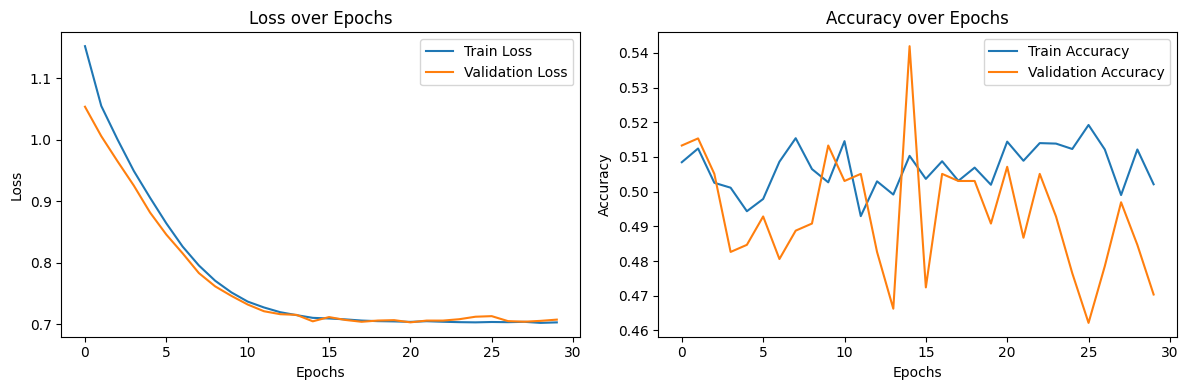

In [35]:
from evaluate import plot_history, evaluate_predictions

plot_history(history)

In [36]:
y_pred = model.predict(x_valid)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [37]:
y_pred = y_pred > 0.5
np.unique(y_pred, return_counts=True)

(array([False,  True]), array([223, 266]))

==========DNN==========
              precision    recall  f1-score   support

     Class 0       0.48      0.43      0.45       252
     Class 1       0.46      0.51      0.49       237

    accuracy                           0.47       489
   macro avg       0.47      0.47      0.47       489
weighted avg       0.47      0.47      0.47       489

Accuracy is 0.4703476482617587
==========DNN==========


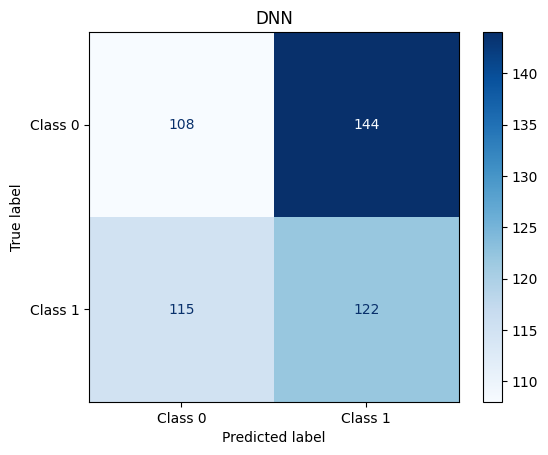

In [38]:
evaluate_predictions(y_valid, y_pred, "DNN")